In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
from lib.models import ResAutoEncoder
import pandas as pd
from lib.datasets import AccRawDataset
from lib.modules import pad_for_windowing
from torch import nn

```
at::Tensor conv_transpose1d(
    const Tensor& input_, const Tensor& weight, const c10::optional<Tensor>& bias_opt,
    IntArrayRef stride, IntArrayRef padding, IntArrayRef output_padding, int64_t groups, IntArrayRef dilation) {
  // See [Note: hacky wrapper removal for optional tensor]
  c10::MaybeOwned<Tensor> bias_maybe_owned = at::borrow_from_optional_tensor(bias_opt);
  const Tensor& bias = *bias_maybe_owned;

  Tensor input;
  bool is_batched;
  std::tie(input, is_batched) = batchify(input_, /*num_spatial_dims=*/ 1, "conv_transpose1d");
  Tensor output;
  if (at::isComplexType(input_.scalar_type())) {
    output = complex_convolution(
      input, weight, bias, stride, padding, dilation, true, output_padding, groups);
  } else {
    output = at::convolution(
      input, weight, bias, stride, padding, dilation, true, output_padding, groups);
  }
  return is_batched ? output : output.squeeze(0);
}
```

In [98]:
test = torch.randn(1, 1, 5)

c1 = nn.Conv1d(1, 2, 3, padding=1, bias=False)
ct1 = nn.ConvTranspose1d(1, 2, 3, padding=1, bias=False)

In [99]:
c1.weight.data = ct1.weight.data.transpose(0,1)

In [49]:
c1(test).equal(ct1(test))

False

In [103]:
c1(test)

tensor([[[ 0.0812, -0.1055, -0.0650,  0.1902, -0.1149],
         [-0.3382,  0.2807, -0.0622, -0.3574, -0.0290]]],
       grad_fn=<ConvolutionBackward0>)

In [104]:
ct1(test)

tensor([[[-1.4574e-01,  9.6994e-02,  4.7218e-02, -2.2213e-01, -2.6276e-04],
         [ 5.4345e-02, -6.9581e-02, -2.5642e-01,  3.5587e-01, -2.2736e-01]]],
       grad_fn=<ConvolutionBackward0>)

In [3]:
acc = pd.read_csv('/home/musa/datasets/eating_raw/11-01_20_54_52/acceleration-11-01_20_54_52.csv', skiprows=1)
X = torch.Tensor(acc[['x','y','z']].values)
# chunk_len = 5 * 60 * 60 * 100 # = 1,800,000 samples ie. 5 hours of recording
# X = X[:len(X) - len(X) % chunk_len]
# X = X.view(-1, chunk_len, 3)

# train test split chunks to get Xtr and Xte
# Xtr = pad_for_windowing(X, 101) # no test set for now
# Xtr = Xtr.flatten(end_dim=1)
Xtr = AccRawDataset(X[:100000], 101)
trainloader = torch.utils.data.DataLoader(Xtr, batch_size=64, shuffle=True)

In [21]:
model = ResAutoEncoder(101, 3).to('cuda:0')
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [22]:
for _ in range(10):

    loss_all = 0
    for X in trainloader:
        X = X.to('cuda:0')
        X_pred = model(X)
        loss = criterion(X_pred, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_all += loss.item()

    print(loss / len(trainloader))



tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.9817e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)


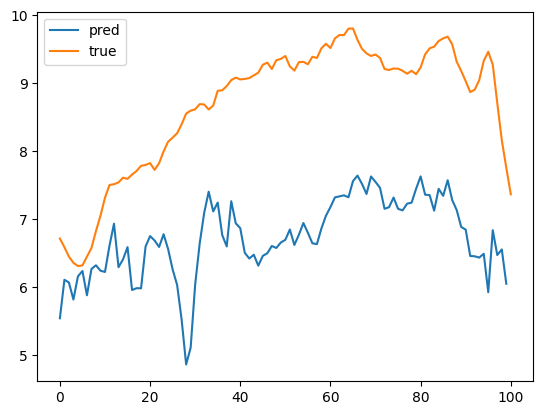

In [40]:
import matplotlib.pyplot as plt
i = 450
plt.plot(model(Xtr[i].to('cuda:0').unsqueeze(0))[0][202:302].detach().cpu(), label='pred')
plt.plot(Xtr[i][202:303], label='true')
plt.legend()